In [1]:
import random

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib import rc as mplrc

import numpy as np

import pandas as pd
import PIL

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, progress
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

from sklearn.model_selection import train_test_split

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split

import torchmetrics

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T

In [2]:
### Set seed for reproducibility
np.random.seed(123)
random.seed(123)
torch.manual_seed(123)

In [ ]:
%load_ext tensorboard

# About

### Latent Space
A latent space is a mathematical representation of data that captures its important features or patterns. It's a way to simplify complex data and extract useful information. The information is, in a sense, compressed into a lower dimensional space that still contains enough information to perform whatever task you want. By encoding into a latent space, essential features from the data are extracted while superfluous data is ignored. Decoding from the latent space uses the essential features to reconstruct a higher dimensional output. This is the basis for many computer vision and natural language processing tasks.

A common task is attempting to output the input. This can be useful for anomaly detection or denoising (with slight modifications to input data). I can, for example, take a 28x28 image, compress it through a series of convolutions into a 16 component latent space vector, then upsample it as I convolve to output a 28x28 image. In this way, I learn how to map input data into a useful representation (encoding) and map this representation into a desired ouput (decoding). This is also the basis for many language models, such as sequence-to-sequence models (translation - universal grammar?).

<img src="imgs/autoencoder_visualization.svg" style="height:600px" class="center" alt="ae"/><br>

A simple representation of an autoencoder. Think of it as a bottle kneck into a smaller latent space and an upsample out of this space back into the output space (whatever that may be). In the above case, it's attempting to recreate the input. This is also how you can do anomaly detection. If you train on non-anomalous data, the autoencoder won't know what to do with anomalies, so there will be a larger error there. Note that this is unsupervised.

<img src="imgs/anomaly_map.png" style="height:400px" class="center" alt="anomaly"/><br>



# Get data

In [571]:
### Download fashion MNIST
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True,)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True,)

In [98]:
# ### Download CIFAR10
# train_dataset = datasets.CIFAR10(
#     root='./data', train=True, download=True,)
# test_dataset = datasets.CIFAR10(
#     root='./data', train=False, download=True,)

Files already downloaded and verified
Files already downloaded and verified


# Prepare data

In [572]:
### MNIST
X_train = train_dataset.data.detach().numpy()
X_test = test_dataset.data.detach().numpy()

In [573]:
# ## cifar
# X_train = train_dataset.data.copy()
# X_test = test_dataset.data.copy()

In [574]:
# normalize
X_train = (X_train - np.min(X_train)) / np.max(X_train - np.min(X_train))
X_test = (X_test - np.min(X_test)) / np.max(X_test - np.min(X_test))

In [575]:
# ## cifar
# X_train = np.moveaxis(X_train, -1, 1)
# X_test = np.moveaxis(X_test, -1, 1)

In [576]:
### PyTorch uses Dataset objects to load the data during training and testing
class ImageDataset(Dataset):

    """Data set"""

    def __init__(
        self,
        X: np.ndarray,
        noisy_X: np.ndarray,
        accelerator_name: str = "mps",
        
    ):
        '''Assign data'''
        self.X = X.astype(np.float32)
        self.noisy_X = noisy_X.astype(np.float32)

        if accelerator_name == "mps":
            self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        elif accelerator_name == "cuda:0":
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device("cpu")
        
        
    def __len__(self):
        '''function to get the length of the dataset'''
        return len(self.X)

    def __getitem__(self, idx: int):
        '''return an x, y pair'''
        x_, noisy_x_ = self.X[idx].astype(np.float32), self.noisy_X[idx].astype(np.float32)

        return torch.from_numpy(x_).float().to(self.device), torch.from_numpy(noisy_x_).float().to(self.device)


In [577]:
# split into validation and training data
val_split = 0.2
X_train, X_val = train_test_split(X_train,
                                  test_size=val_split,
                                  random_state=123)

In [578]:
### fashion MNIST
# add channel axes (N, H, W) -> (N, C, H, W) because C = 1 in this case
X_train = X_train[:, np.newaxis, :, :].astype(np.float32)
X_test = X_test[:, np.newaxis, :, :].astype(np.float32)
X_val = X_val[:, np.newaxis, :, :].astype(np.float32)

In [579]:
noisy_X_train = X_train.copy().astype(np.float32)
noisy_X_test = X_test.copy().astype(np.float32)
noisy_X_val = X_val.copy().astype(np.float32)

In [580]:
### fashion mnist
noise_level = 0.1

## cifar
# noise_level = 0.05

In [581]:
noisy_X_train += noise_level * np.random.standard_normal(X_train.shape)
noisy_X_train -= np.min(noisy_X_train)
noisy_X_train /= np.max(noisy_X_train)

noisy_X_val += noise_level * np.random.standard_normal(X_val.shape)
noisy_X_val -= np.min(noisy_X_val)
noisy_X_val /= np.max(noisy_X_val)

noisy_X_test += noise_level * np.random.standard_normal(X_test.shape)
noisy_X_test -= np.min(noisy_X_test)
noisy_X_test /= np.max(noisy_X_test)

In [582]:
# get H = W
input_xy = X_train.shape[-1]

In [583]:
batch_size = 64

In [584]:
##### Now we actually make the dataset and dataloader in PyTorch fashion
train_data = ImageDataset(X_train, noisy_X_train)
val_data = ImageDataset(X_val, noisy_X_val)
test_data = ImageDataset(X_test, noisy_X_test)

# make the loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data)

# Define Models

## Encoder

In [633]:
class Encoder(pl.LightningModule):

    def __init__(self, 
                 kernel_size: int = 3, 
                 dropout: float = 0.25,
                 cnn_layer_dims: list = [126, 64, 32],
                 padding: int = 1, 
                 stride: int = 2,
                 n_channels: int = 1,
                 input_xy: int = 28, 
                 lr: float = 1e-4, 
                 weight_decay: float = 0., 
                 eps: float = 5e-7, 
                 activation: torch.nn.modules.activation = nn.GELU(),
                 use_wandb: bool=False,
                 scheduler_name: str = "none",
                 step_size: int = 5,
                 gamma: float = 0.5,
                 ) -> None:
        super().__init__()
        ### Always need to call above function first in order
        ### to properly initialize a model
        '''Basic CNN to classify fashion MNIST
        We aren't going to both with some of the fancier stuff from the MLP, but it's easy enough to apply here too
        '''
        
        # model parameters
        self.cnn_dims = cnn_layer_dims
        self.activation = activation
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.n_cnn_layers = len(cnn_layer_dims)
        self.scheduler_name = scheduler_name
        # if using a scheduler
        self.step_size = step_size
        self.gamma = gamma
        
        # log using WandB or TensorBoard
        self.use_wandb = use_wandb
        
        # what the input data looks like (allows construction of graph for logging)
        # (batch_size, channels, height, width)
        self.example_input_array = torch.zeros(
            (1, n_channels, input_xy, input_xy,),
            dtype=torch.float32
        )
        
        #### Construct the layers #####
        ## get input layer
        ## shape = (C, H, W) -> (cnn_layer_dim, H, W)
        self.input_cnn = nn.Conv2d(n_channels, cnn_layer_dims[0], 
                                   kernel_size=kernel_size, stride=stride, padding=padding)
        
        ## make CNN hidden layers
        self.encoding_layers = []
        for i in range(1, self.n_cnn_layers):
            self.encoding_layers.append(nn.Conv2d(cnn_layer_dims[i-1], cnn_layer_dims[i], 
                                       kernel_size=kernel_size, stride=stride, padding=padding))

        self.encoding_layers = nn.ModuleList(self.encoding_layers)
        
        
    def forward(self, x):
        '''Determines how data is passed through the network, 
           i.e creates the connectivity of the network'''
        
        ## send through input layer and activate
        x = self.activation(self.input_cnn(x))
            
        # pass through CNN
        for layer in self.encoding_layers:
            # pass through layer and activate
            x = layer(x)
            x = self.activation(x)
        
        return x

    def configure_optimizers(self) -> (list, list):
        """Set up the optimizer and potential learning rate scheduler"""
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            eps=self.eps,
            weight_decay=self.weight_decay,
        )

        if self.scheduler_name == "none":
            return self.optimizer

        ### this decreases the learning rate by a factor of gamma every step_size
        self.scheduler = MultiStepLR(
            self.optimizer,
            list(range(0, self.trainer.max_epochs, self.step_size)),
            gamma=self.gamma,
        )

        return [self.optimizer], [{"scheduler": self.scheduler, "interval": "epoch"}]
        
    #### need to add these two things in case the scheduler is used ####
    def lr_scheduler_step(self, scheduler, metric) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def on_epoch_end(self) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def process_batch(self, batch, step: str = "train"):
        """Passes and logs a batch for a given type of step (test, train, validation)"""
        
        # get data (batch includes labels, which we don't need)
        _, noisy_x = batch

        # pass through network
        # logits have no activation applied
        return self(noisy_x)
        
    def training_step(self, batch, batch_idx):
        """What do do with a training batch"""
        
        return self.process_batch(batch, step="train")

    def validation_step(self, batch, batch_idx):
        '''Validation step (at the end of each epoch)'''
        
        return self.process_batch(batch, step="val")
        
    def test_step(self, batch, batch_idx):
        
        '''Test step is essentially the same as a validation step in this instance'''
        return self.process_batch(batch, step="test")

    def activation_maps(self, x, depth: int=0) -> np.ndarray:
        
        '''Gets output activation of an arbitary CNN layer'''
        
        i = 0
        # input layer
        x = self.activation(self.input_cnn(x))
        
        if depth == 0:
            return x.detach().numpy()
        
        i += 1
        x = F.max_pool2d(x, 2)
            
        # pass through CNN and return when you reach the appropriate depth
        for layer in self.encoding_layers:
            x = self.activation(layer(x))
            if i == depth:
                return x.detach().numpy()
            i += 1
            x = F.max_pool2d(x, 2)


## Decoder

In [634]:
class Decoder(pl.LightningModule):

    def __init__(self, 
                 kernel_size: int = 3, 
                 dropout: float = 0.25,
                 cnn_layer_dims: list = [32, 64, 128],
                 padding: int = 1, 
                 stride: int = 2,
                 image_input_channels: int = 1,
                 n_input_channels: int = 128,
                 input_xy: int = 4, 
                 lr: float = 1e-4, 
                 weight_decay: float = 0., 
                 eps: float = 5e-7, 
                 activation: torch.nn.modules.activation = F.gelu,
                 use_wandb: bool=False,
                 scheduler_name: str = "none",
                 step_size: int = 5,
                 gamma: float = 0.5,
                 output_padding: int = 1,
                 ) -> None:
        super().__init__()
        ### Always need to call above function first in order
        ### to properly initialize a model
        '''Basic CNN to classify fashion MNIST
        We aren't going to both with some of the fancier stuff from the MLP, but it's easy enough to apply here too
        '''
        
        # model parameters
        self.cnn_dims = cnn_layer_dims
        self.image_input_channels = image_input_channels
        self.activation = activation
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.n_cnn_layers = len(cnn_layer_dims)
        self.scheduler_name = scheduler_name
        # if using a scheduler
        self.step_size = step_size
        self.gamma = gamma
        
        # log using WandB or TensorBoard
        self.use_wandb = use_wandb

        # what the input data looks like (allows construction of graph for logging)
        # (batch_size, channels, height, width)
        self.example_input_array = torch.zeros(
            (1, n_input_channels, input_xy, input_xy,),
            dtype=torch.float32
        )
        
        #### Construct the layers #####
        ## get input layer
        ## shape = (C, H, W) -> (cnn_layer_dim, H, W)
        # self.input_cnn = nn.ConvTranspose2d(n_input_channels,
        #                                     cnn_layer_dims[0], 
        #                                     kernel_size=kernel_size, 
        #                                     # output_padding=output_padding, 
        #                                     padding=padding, stride=stride
        #                                   )

        ## make CNN hidden layers
        self.decoding_layers = []
        for i in range(0, self.n_cnn_layers):

            ### ConvTranspose2d __upscales__ the data with output padding
            self.decoding_layers.append(nn.ConvTranspose2d(cnn_layer_dims[i-1] if i != 0 else n_input_channels,
                                                           cnn_layer_dims[i] if i != self.n_cnn_layers - 1 else self.image_input_channels, 
                                                           kernel_size=kernel_size, 
                                                           output_padding=output_padding, 
                                                           padding=padding, 
                                                           stride=stride
                                                          ))

            # self.decoding_layers.append(nn.Conv2d(cnn_layer_dims[i], cnn_layer_dims[i], 
                                       # kernel_size=kernel_size, stride=stride, padding=padding))

        # self.decoding_layers.append(nn.ConvTranspose2d(cnn_layer_dims[-1],
        #                                                self.image_input_channels, 
        #                                                kernel_size=kernel_size, 
        #                                                output_padding=output_padding, 
        #                                                # padding=padding, 
        #                                                stride=stride,
        #                                             ))

        # self.decoding_layers.append(nn.Tanh())

        self.decoding_layers = nn.ModuleList(self.decoding_layers)

        # self.init_weights()

    # def init_weights(self) -> None:
        # ### does some fancy layer weight initialization
        # for layer in self.decoding_layers:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.xavier_uniform_(layer.weight)
        
        
    def forward(self, x):
        '''Determines how data is passed through the network, 
           i.e creates the connectivity of the network'''
        ## send through input layer and activate
        # x = self.activation(self.input_cnn(x))
        # pass through CNN
        for layer in self.decoding_layers:
            # pass through layer
            x = layer(x)
            x = self.activation(x)

        return x

    def configure_optimizers(self) -> (list, list):
        """Set up the optimizer and potential learning rate scheduler"""
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            eps=self.eps,
            weight_decay=self.weight_decay,
        )

        if self.scheduler_name == "none":
            return self.optimizer

        ### this decreases the learning rate by a factor of gamma every step_size
        self.scheduler = MultiStepLR(
            self.optimizer,
            list(range(0, self.trainer.max_epochs, self.step_size)),
            gamma=self.gamma,
        )

        return [self.optimizer], [{"scheduler": self.scheduler, "interval": "epoch"}]
        
    #### need to add these two things in case the scheduler is used ####
    def lr_scheduler_step(self, scheduler, metric) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def on_epoch_end(self) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def process_batch(self, batch, step: str = "train"):
        """Passes and logs a batch for a given type of step (test, train, validation)"""
        
        # get data (batch includes labels, which we don't need)
        _, noisy_x = batch

        # pass through network
        # logits have no activation applied
        return self(noisy_x)
        
    def training_step(self, batch, batch_idx):
        """What do do with a training batch"""
        
        return self.process_batch(batch, step="train")

    def validation_step(self, batch, batch_idx):
        '''Validation step (at the end of each epoch)'''
        
        return self.process_batch(batch, step="val")
        
    def test_step(self, batch, batch_idx):
        
        '''Test step is essentially the same as a validation step in this instance'''
        return self.process_batch(batch, step="test")

    def activation_maps(self, x, depth: int=0) -> np.ndarray:
        
        '''Gets output activation of an arbitary CNN layer'''
        
        i = 0
        # input layer
        x = self.activation(self.input_cnn(x))
        
        if depth == 0:
            return x.detach().numpy()
        
        i += 1
        x = F.max_pool2d(x, 2)
            
        # pass through CNN and return when you reach the appropriate depth
        for layer in self.decoding_layers:
            x = self.activation(layer(x))
            if i == depth:
                return x.detach().numpy()
            i += 1
            x = F.max_pool2d(x, 2)


## Entire network

In [635]:
class Autoencoder(pl.LightningModule):

    def __init__(self, 
                 kernel_size: int = 3, 
                 dropout: float = 0.25,
                 cnn_layer_dims: list = [128, 64, 32],
                 padding: int = 1, 
                 stride: int = 2,
                 image_input_channels: int = 1,
                 latent_dim: int = 32,
                 input_xy: int = 28, 
                 lr: float = 1e-4, 
                 weight_decay: float = 0., 
                 eps: float = 5e-7, 
                 activation: torch.nn.modules.activation = F.gelu,
                 use_wandb: bool=False,
                 scheduler_name: str = "none",
                 step_size: int = 5,
                 gamma: float = 0.5,
                 output_padding: int = 1,
                 use_l2: bool = False,
                 ) -> None:
        super().__init__()
        ### Always need to call above function first in order
        ### to properly initialize a model
        '''Basic CNN to denoise images
        '''
        
        # model parameters
        self.cnn_dims = cnn_layer_dims
        self.image_input_channels = image_input_channels
        self.activation = activation
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.n_channels = len(cnn_layer_dims)
        self.scheduler_name = scheduler_name
        # if using a scheduler
        self.step_size = step_size
        self.gamma = gamma

        self.latent_dim = latent_dim

        self.loss_fn = nn.MSELoss()
        
        # log using WandB or TensorBoard
        self.use_wandb = use_wandb

        # add L2 regularization
        self.use_l2 = use_l2

        # what the input data looks like (allows construction of graph for logging)
        # (batch_size, channels, height, width)
        self.example_input_array = torch.zeros(
            (1, image_input_channels, input_xy, input_xy,),
            dtype=torch.float32
        )
        

        self.encoder = Encoder(
                  cnn_layer_dims=cnn_layer_dims, 
                  input_xy=input_xy, 
                  activation=activation, 
                  n_channels=n_channels,
                  use_wandb=use_wandb,
                  dropout=dropout, 
                  padding=padding,
                  eps=eps, lr=lr, 
                  weight_decay=weight_decay,
                  scheduler_name=scheduler_name,
                  gamma=gamma,
                  step_size=step_size,
        )

        # get output dimensions of encoder
        self.encoded_cxy, self.flat_dim = self._flat_layer_size()

        self.decoder = Decoder(
                  cnn_layer_dims=cnn_layer_dims[::-1], 
                  input_xy=self.encoded_cxy[-1], 
                  activation=activation, 
                  n_input_channels=cnn_layer_dims[-1],
                  image_input_channels=image_input_channels,
                  use_wandb=use_wandb,
                  dropout=dropout, 
                  padding=padding,
                  eps=eps, lr=lr, 
                  weight_decay=weight_decay,
                  scheduler_name=scheduler_name,
                  gamma=gamma,
                  step_size=step_size,
                  output_padding=output_padding,
        )


        self.latent_encoder = nn.Linear(self.flat_dim, self.latent_dim)
        self.latent_decoder = nn.Linear(self.latent_dim, self.flat_dim)

        self.init_weights()

    def init_weights(self) -> None:
        ### does some fancy layer weight initialization
        nn.init.xavier_uniform_(self.latent_decoder.weight)
        nn.init.xavier_uniform_(self.latent_encoder.weight)
        
    def forward(self, x):
        '''Determines how data is passed through the network, 
           i.e creates the connectivity of the network'''
        
        # encode
        x = self.encoder(x)

        # put into latent space
        x = nn.Flatten()(x)
        x = self.activation(self.latent_encoder(x))

        # bring out of latent space
        x = self.activation(self.latent_decoder(x))

        # decode
        x = x.reshape(x.shape[0], 
                      -1, 
                      self.encoded_cxy[-1], 
                      self.encoded_cxy[-1])
        
        x = self.decoder(x)

        return nn.ReLU()(x)

    def configure_optimizers(self) -> (list, list):
        """Set up the optimizer and potential learning rate scheduler"""
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            eps=self.eps,
            weight_decay=self.weight_decay,
        )

        if self.scheduler_name == "none":
            return self.optimizer

        ### this decreases the learning rate by a factor of gamma every step_size
        self.scheduler = MultiStepLR(
            self.optimizer,
            list(range(0, self.trainer.max_epochs, self.step_size)),
            gamma=self.gamma,
        )

        return [self.optimizer], [{"scheduler": self.scheduler, "interval": "epoch"}]
        
    #### need to add these two things in case the scheduler is used ####
    def lr_scheduler_step(self, scheduler, metric) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def on_epoch_end(self) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def process_batch(self, batch, step: str = "train"):
        """Passes and logs a batch for a given type of step (test, train, validation)"""
        
        # get data (batch includes labels, which we don't need)
        x, noisy_x = batch

        # pass through network
        denoised_x = self(noisy_x)

        # flatten to get easy MSE
        denoised_x = nn.Flatten()(denoised_x)
        x = nn.Flatten()(x)

        loss = self.loss_fn(x, denoised_x)

        if self.use_l2:
            # Add L2 regularization to the loss
            l2_regularization = 0.0  # You can adjust the regularization strength
            for param in self.parameters():
                l2_regularization += torch.norm(param, 2)  # L2 norm of each parameter
            self.log(f"{step}_L2", l2_regularization)
            loss += l2_regularization

        self.log(f"{step}_loss", loss)

        return loss

    def training_step(self, batch, batch_idx):
        """What do do with a training batch"""
        
        return self.process_batch(batch, step="train")

    def validation_step(self, batch, batch_idx):
        '''Validation step (at the end of each epoch)'''
        
        return self.process_batch(batch, step="val")
        
    def test_step(self, batch, batch_idx):
        
        '''Test step is essentially the same as a validation step in this instance'''
        return self.process_batch(batch, step="test")

    def _flat_layer_size(self) -> int:
        
        '''Gets the dimension of the flattened CNN output layer'''
        
        x = self.example_input_array
        
        # Pass the input tensor through the CNN layers
        x = self.encoder(x)

        array_dim = x.size()
        # Calculate the flattened layer dimension
        flattened_dim = x.view(1, -1).size(1)

        return array_dim, flattened_dim



## Initialize

In [636]:
# model hyper parameters (fashion MNIST)
lr = 1e-3
eps = 1e-8
weight_decay = 1e-6
dropout = 0.25
cnn_layer_dims  = [128, 64,]
n_cnn_layers = len(cnn_layer_dims)
latent_dim = 16
activation = F.gelu
n_channels = 1
stride = 2
kernel_size = 3
padding = 1
output_padding = 1
scheduler_name = "step"
gamma = 0.5
step_size = 5
use_l2 = False # L2 regularization

## WandB stuff
# log with WandB or TensorBoard
use_wandb = False
# do hyperparameter sweep with WandB
use_sweep = False
# WandB project name
project_name = "FashioMNIST_AE"
# WandB lab name
entity = ''

In [637]:
# # model hyper parameters 
# lr = 5e-4
# eps = 1e-8
# weight_decay = 1e-6
# dropout = 0.25
# cnn_layer_dims  = [128, 64, 32,]
# n_cnn_layers = len(cnn_layer_dims)
# latent_dim = 16
# activation = F.gelu
# n_channels = 3
# stride = 2
# kernel_size = 3
# padding = 1
# output_padding = 1
# scheduler_name = "step"
# gamma = 0.5
# step_size = 5
# use_l2 = False # L2 regularization

# ## WandB stuff
# # log with WandB or TensorBoard
# use_wandb = False
# # do hyperparameter sweep with WandB
# use_sweep = False
# # WandB project name
# project_name = 'CIFAR10_AE'
# # WandB lab name
# entity = ''

In [638]:
model = Autoencoder(latent_dim=latent_dim,
                  cnn_layer_dims=cnn_layer_dims, 
                  input_xy=input_xy, 
                  activation=activation, 
                  image_input_channels=n_channels,
                  use_wandb=use_wandb,
                  dropout=dropout, 
                  eps=eps, 
                  lr=lr, 
                  weight_decay=weight_decay,
                  scheduler_name=scheduler_name,
                  gamma=gamma,
                  step_size=step_size,
                  stride=stride,
                  padding=padding,
                  output_padding=output_padding,
                  use_l2=use_l2,
               )

# Train

In [639]:
num_epochs = 25

In [640]:
accelerator_name = "mps"
# accelerator_name = "cpu"

In [641]:
# boilerplate to get GPU if possible
if accelerator_name == "mps":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif accelerator_name == "cuda":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [642]:
if not use_wandb:
    # %load_ext tensorboard
    # cnn_logger = TensorBoardLogger("ae_logs", name="simple_cifar_fashion_ae")
    cnn_logger = TensorBoardLogger("ae_logs", name="simple_mnist_fashion_ae")
    run_name = "ae_cnn"
else:
    logger_kwargs = {
        "resume": "allow",
        "config": model_hparams,
    }
    cnn_logger = WandbLogger(project=project_name, entity=entity, **logger_kwargs)
    cnn_run_name = cnn_logger.experiment.name

In [643]:
#### necessary for newer PTL versions
devices = 1
accelerator = "gpu" if devices == 1 else "cpu"

# make the trainer
trainer = pl.Trainer(
    devices=devices,
    accelerator=accelerator,
    max_epochs=num_epochs,
    log_every_n_steps=1,
    logger=cnn_logger,
    # reload_dataloaders_every_epoch=True,
    callbacks=[
        # ModelCheckpoint(
        #     save_weights_only=False,
        #     mode="min",
        #     monitor="val_acc",
        #     save_top_k=1,
        #     every_n_epochs=1,
        #     save_on_train_epoch_end=False,
        #     dirpath=f"/AE_Checkpoints/{run_name}/",
        #     filename=f"ae_checkpoint_{run_name}",
        # ),
        LearningRateMonitor("epoch"),
        progress.TQDMProgressBar(refresh_rate=1),
        EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=10,
            verbose=False,
            mode="min",
        ),
    ],
)
trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [644]:
model = model.to(device)

In [645]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name           | Type    | Params | In sizes       | Out sizes     
-----------------------------------------------------------------------------
0 | loss_fn        | MSELoss | 0      | ?              | ?             
1 | encoder        | Encoder | 75.1 K | [1, 1, 28, 28] | [1, 64, 7, 7] 
2 | decoder        | Decoder | 37.5 K | [1, 64, 7, 7]  | [1, 1, 28, 28]
3 | latent_encoder | Linear  | 50.2 K | [1, 3136]      | [1, 16]       
4 | latent_decoder | Linear  | 53.3 K | [1, 16]        | [1, 3136]     
-----------------------------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.864     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


# Test

In [646]:
## Get test metrics
test_results = trainer.test(model, test_loader)
print(test_results)

/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.011740208603441715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.011740208603441715}]


In [670]:
## open up TensorBoard
if not use_wandb:
    %tensorboard --logdir ae_logs --port 6008

## Look at images

In [647]:
# plotting a prameters
scale_factor = 1.5

labels = 16 * scale_factor
ticks = 10 * scale_factor
# ticks = 10 * scale_factor
legends = 12 * scale_factor
text = 14 * scale_factor
titles = 22 * scale_factor
lw = 3 * scale_factor
ps = 200 * scale_factor
cmap = 'magma'

colors = ['firebrick', 'steelblue', 'darkorange', 'darkviolet', 'cyan', 'magenta', 'darkgreen', 'deeppink']
markers = ['x', 'o', '+', '>', '*', 'D', '4']
linestyles = ['-', '--', ':', '-.']

In [648]:
def plot_image_panel(images: list, labels: list=["Noisy", "Denoised", "Clean"], cmap: str='viridis', show_ticks: bool=True):
    
    '''Plots a 3x1 panel of images'''
    
    mplrc('xtick', labelsize=ticks) 
    mplrc('ytick', labelsize=ticks)
    mplrc('axes', titlesize=titles)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16., 12.))
    
    for (i, image) in enumerate(images):
        ax = axs[i]
        
        ax.imshow(image, cmap=cmap)
        if len(labels) > i and labels[i] != '':
            ax.set_title(labels[i])
            
        if not show_ticks:
            ax.set_xticks([])
            ax.set_yticks([])
        elif i > 0:
            ax.set_yticks([])

    plt.tight_layout()
    
    plt.show()

In [649]:
### Do inference on test set
## need to turn into torch tensor first
# X_test_infer = torch.from_numpy(X_test).float()
X_noisy_test_infer = torch.from_numpy(noisy_X_test).float()

In [650]:
X_noisy_pred_tensor = model(X_noisy_test_infer)

In [651]:
X_noisy_pred = X_noisy_pred_tensor.detach().cpu().numpy()

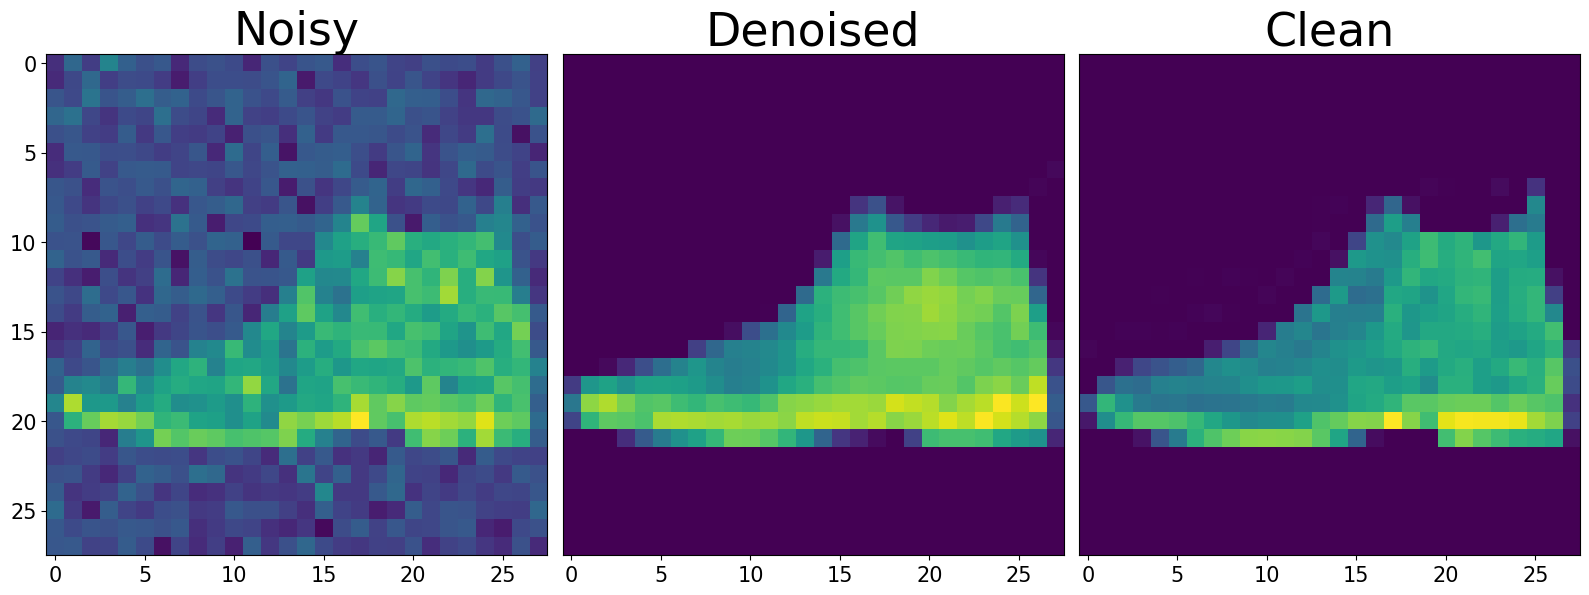

In [652]:
i = 0
plot_image_panel([noisy_X_test[i].squeeze(), X_noisy_pred[i].squeeze(), X_test[i].squeeze()])

# Variational Autoencoder

Autoencoders learn deterministic mapping into and out of the latent space. VAEs learn *probabilistic* mapping. That is, they learn a latent space distribution (often a normal distribution). The encoder maps into this (learned) distribution, and the decoder samples out of this distribution to give a final result.

The extra power here comes from the probabilistic latent space. The network is (hopefully) trained such that any sample from the latent space can be decoded properly. If I put in Gaussian noise into the decoder, I should get something coherent out (like an approximate MNIST image). This allows the generation of an arbitrary number of outputs.

<img src="imgs/vae.png" style="height:300px" class="center" alt="vae"/><br>

Schematic of VAE. Everything is done probabilistically. The encoder outputs a mean ($\mu$) and standard deviations ($\sigma$) that describe a normal distrubtion, sampling outputs from this distrubtion. This is equivalent to sampling latent variables that are passed through the decoder. The decoder takes multiple samples from this latent space and decodes them into the output space. This defines an output *distrubtion*. The training objective for a VAE is to maximize the evidence lower bound (ELBO), which is a lower-bound approximation to the log-likelihood of the data (we use log-likelihood because it turns multiplication into addition). 

$$\mathrm{ELBO} = \mathbb{E}[log(p(x | z))] - KL[q(z|x) || p(z)]$$

$$KL[q(z|x) || p(z)] = \frac{1}{2} \left[\sum_{i = 1}^{D}(\sigma_{i}^{2} + \mu_{i}^{2} - log(\sigma_{i}^{2}) -1)\right]$$ where $\sigma_{i}$ and $\mu_{i}$ are the standard deviation and mean of the normal distrubtion describing the $i^{th}$ component of the latent space. The KL divergence means the divergence of $q(z|x)$ from $p(z)$, i.e., measures the distribution of the latent space given the input and the expected output (assumed normal distribution with $\mu = 0$ and $\sigma = 1$). This encourages the encoder to approximate a standard normal distrubtion while giving it the freedom to add some minor adjustments. 

$\mathbb{E}[log(p(x | z))$ represents the reconstruction loss (not MSE!). Reconstruction loss is an attempt to maximize the likelihood of generating the observed data from the latent space. The intuition here is that reconstruction loss attempts to recreate the data while the KL divergence attempts to create a general distribution. So there's a tradeoff between reconstruction and generalizing.

After training, we can simple feed Gaussian noise into the decoder to generate novel samples. This is the first example of generative networks that we have seen.

## Functions

In [494]:
def get_kl_divergence(z: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> float:
    """This calculates the KL divergence"""

    return 0.5 * (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1.).sum()


def get_reconstruction_loss(x: torch.Tensor, decoded_x: torch.Tensor, epsilon: nn.Parameter) -> torch.Tensor:
    """Gets reconstruction loss of latent space from a standard distrubtion"""

    # get predicted distribtion
    exp_scale = torch.exp(epsilon)
    dist = torch.distributions.Normal(decoded_x, exp_scale)

    # measure get p(x|z) using the predicted distribution
    log_pxz = dist.log_prob(x)
    
    return log_pxz.sum(dim=(1, 2, 3))

## Model

In [495]:
class VariationalAutoencoder(pl.LightningModule):

    def __init__(self, 
                 kernel_size: int = 3, 
                 dropout: float = 0.25,
                 cnn_layer_dims: list = [128, 64, 32],
                 padding: int = 1, 
                 stride: int = 2,
                 image_input_channels: int = 1,
                 latent_dim: int = 32,
                 input_xy: int = 28, 
                 lr: float = 1e-4, 
                 weight_decay: float = 0., 
                 eps: float = 5e-7, 
                 activation: torch.nn.modules.activation = F.gelu,
                 use_wandb: bool=False,
                 scheduler_name: str = "none",
                 step_size: int = 5,
                 gamma: float = 0.5,
                 output_padding: int = 1,
                 ) -> None:
        super().__init__()
        ### Always need to call above function first in order
        ### to properly initialize a model
        '''Basic CNN to classify fashion MNIST
        We aren't going to both with some of the fancier stuff from the MLP, but it's easy enough to apply here too
        '''
        
        # model parameters
        self.cnn_dims = cnn_layer_dims
        self.image_input_channels = image_input_channels
        self.activation = activation
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.n_channels = len(cnn_layer_dims)
        self.scheduler_name = scheduler_name
        # if using a scheduler
        self.step_size = step_size
        self.gamma = gamma

        # standard normal (attempted p(z))
        self.normal_distribtion = torch.distributions.Normal(0., 1.)

        self.latent_dim = latent_dim
        
        # log using WandB or TensorBoard
        self.use_wandb = use_wandb

        # what the input data looks like (allows construction of graph for logging)
        # (batch_size, channels, height, width)
        self.example_input_array = torch.zeros(
            (1, image_input_channels, input_xy, input_xy,),
            dtype=torch.float32
        )
        

        # we still use our old encoder/decoder
        self.encoder = Encoder(
                  cnn_layer_dims=cnn_layer_dims, 
                  input_xy=input_xy, 
                  activation=activation, 
                  n_channels=n_channels,
                  use_wandb=use_wandb,
                  dropout=dropout, 
                  padding=padding,
                  eps=eps, lr=lr, 
                  weight_decay=weight_decay,
                  scheduler_name=scheduler_name,
                  gamma=gamma,
                  step_size=step_size,
        )

        # get output dimensions of encoder
        self.encoded_cxy, self.flat_dim = self._flat_layer_size()

        self.decoder = Decoder(
                  cnn_layer_dims=cnn_layer_dims[::-1], 
                  input_xy=self.encoded_cxy[-1], 
                  activation=activation, 
                  n_input_channels=cnn_layer_dims[-1],
                  image_input_channels=image_input_channels,
                  use_wandb=use_wandb,
                  dropout=dropout, 
                  padding=padding,
                  eps=eps, lr=lr, 
                  weight_decay=weight_decay,
                  scheduler_name=scheduler_name,
                  gamma=gamma,
                  step_size=step_size,
                  output_padding=output_padding,
        )


        self.mu = nn.Linear(self.flat_dim, self.latent_dim)
        self.sigma = nn.Linear(self.flat_dim, self.latent_dim)
        self.epsilon = nn.Parameter(torch.Tensor([0.]))

        self.init_weights()

    def init_weights(self) -> None:
        ### does some fancy layer weight initialization
        nn.init.xavier_uniform_(self.mu.weight)
        nn.init.xavier_uniform_(self.sigma.weight)
        
    def forward(self, x):
        '''Determines how data is passed through the network, 
           i.e creates the connectivity of the network'''
        
        # encode
        x = self.encoder(x)

        # put into latent space
        x = nn.Flatten()(x)

        # get distribution of latent space
        mu_hat = self.mu(x)
        sigma_hat = torch.exp(self.sigma(x))

        # decode
        x = x.reshape(x.shape[0], 
                      -1, 
                      self.encoded_cxy[-1], 
                      self.encoded_cxy[-1])

        # import pdb; pdb.set_trace()
        
        x = self.decoder(x)
        return nn.ReLU()(x), mu_hat, sigma_hat

    def configure_optimizers(self) -> (list, list):
        """Set up the optimizer and potential learning rate scheduler"""
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            eps=self.eps,
            weight_decay=self.weight_decay,
        )

        if self.scheduler_name == "none":
            return self.optimizer

        ### this decreases the learning rate by a factor of gamma every step_size
        self.scheduler = MultiStepLR(
            self.optimizer,
            list(range(0, self.trainer.max_epochs, self.step_size)),
            gamma=self.gamma,
        )

        return [self.optimizer], [{"scheduler": self.scheduler, "interval": "epoch"}]
        
    #### need to add these two things in case the scheduler is used ####
    def lr_scheduler_step(self, scheduler, metric) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def on_epoch_end(self) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    def process_batch(self, batch, step: str = "train"):
        """Passes and logs a batch for a given type of step (test, train, validation)"""
        
        # get data (batch includes labels, which we don't need)
        x, _ = batch

        # pass through network
        x_pred, mu_hat, sigma_hat = self(x)

        # get latent variables
        z = mu_hat + sigma_hat * self.normal_distribtion.sample(mu_hat.shape).to(self.device)

        recon_loss = get_reconstruction_loss(x, x_pred, self.epsilon).mean()
        kl_divergence = get_kl_divergence(z, mu_hat, sigma_hat)

        loss = recon_loss - kl_divergence

        self.log(f"{step}_loss", loss)
        self.log(f"{step}_avg_reconstruction_loss", recon_loss)
        self.log(f"{step}_kl_divergence", kl_divergence)
        self.log(f"{step}_avg_mu", mu_hat.mean())
        self.log(f"{step}_avg_sigma", sigma_hat.mean())

        return loss

    def training_step(self, batch, batch_idx):
        """What do do with a training batch"""
        
        return self.process_batch(batch, step="train")

    def validation_step(self, batch, batch_idx):
        '''Validation step (at the end of each epoch)'''
        
        return self.process_batch(batch, step="val")
        
    def test_step(self, batch, batch_idx):
        
        '''Test step is essentially the same as a validation step in this instance'''
        return self.process_batch(batch, step="test")

    def _flat_layer_size(self) -> int:
        
        '''Gets the dimension of the flattened CNN output layer'''
        
        x = self.example_input_array
        
        # Pass the input tensor through the CNN layers
        x = self.encoder(x)

        array_dim = x.size()
        # Calculate the flattened layer dimension
        flattened_dim = x.view(1, -1).size(1)

        return array_dim, flattened_dim



## Initialize

In [653]:
# model hyper parameters (fashion MNIST)
lr = 1e-3
eps = 1e-8
weight_decay = 1e-6
dropout = 0.25
cnn_layer_dims  = [128, 64,]
n_cnn_layers = len(cnn_layer_dims)
latent_dim = 32
activation = F.gelu
n_channels = 1
stride = 2
kernel_size = 3
padding = 1
output_padding = 1
scheduler_name = "step"
gamma = 0.5
step_size = 5
use_l2 = False # L2 regularization

## WandB stuff
# log with WandB or TensorBoard
use_wandb = False
# do hyperparameter sweep with WandB
use_sweep = False
# WandB project name
project_name = "FashioMNIST_AE"
# WandB lab name
entity = ''

In [505]:
# # model hyper parameters  (cifar)
# lr = 1e-3
# eps = 1e-8
# weight_decay = 1e-7
# dropout = 0.25
# cnn_layer_dims  = [128, 64, 32,]
# n_cnn_layers = len(cnn_layer_dims)
# latent_dim = 32
# activation = F.gelu
# n_channels = 3
# stride = 2
# kernel_size = 3
# padding = 1
# output_padding = 1
# scheduler_name = "step"
# gamma = 0.5
# step_size = 5

# ## WandB stuff
# # log with WandB or TensorBoard
# use_wandb = False
# # do hyperparameter sweep with WandB
# use_sweep = False
# # WandB project name
# project_name = 'CIFAR_VAE'
# # WandB lab name
# entity = ''

In [654]:
vae_model = VariationalAutoencoder(latent_dim=latent_dim,
                  cnn_layer_dims=cnn_layer_dims, 
                  input_xy=input_xy, 
                  activation=activation, 
                  image_input_channels=n_channels,
                  use_wandb=use_wandb,
                  dropout=dropout, 
                  eps=eps, 
                  lr=lr, 
                  weight_decay=weight_decay,
                  scheduler_name=scheduler_name,
                  gamma=gamma,
                  step_size=step_size,
                  stride=stride,
                  padding=padding,
                  output_padding=output_padding,
               )

## Train

In [655]:
num_epochs = 50

In [656]:
accelerator_name = "mps"
# accelerator_name = "cpu"

In [657]:
# boilerplate to get GPU if possible
if accelerator_name == "mps":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif accelerator_name == "cuda":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [658]:
vae_model = vae_model.to(device)

In [659]:
vae_model

VariationalAutoencoder(
  (encoder): Encoder(
    (input_cnn): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (encoding_layers): ModuleList(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (decoding_layers): ModuleList(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    )
  )
  (mu): Linear(in_features=3136, out_features=32, bias=True)
  (sigma): Linear(in_features=3136, out_features=32, bias=True)
)

In [660]:
if not use_wandb:
    # %load_ext tensorboard
    vae_logger = TensorBoardLogger("vae_logs", name="simple_cifar_vae")
    run_name = "vae_cnn"
else:
    logger_kwargs = {
        "resume": "allow",
        "config": model_hparams,
    }
    vae_logger = WandbLogger(project=project_name, entity=entity, **logger_kwargs)
    vae_run_name = vae_logger.experiment.name

In [661]:
#### necessary for newer PTL versions
devices = 1
accelerator = "cpu" if device.type == "cpu" else "gpu"

# make the trainer
vae_trainer = pl.Trainer(
    devices=devices,
    accelerator=accelerator,
    max_epochs=num_epochs,
    log_every_n_steps=1,
    logger=vae_logger,
    # reload_dataloaders_every_epoch=True,
    callbacks=[
        # ModelCheckpoint(
        #     save_weights_only=False,
        #     mode="min",
        #     monitor="val_acc",
        #     save_top_k=1,
        #     every_n_epochs=1,
        #     save_on_train_epoch_end=False,
        #     dirpath=f"/AE_Checkpoints/{run_name}/",
        #     filename=f"ae_checkpoint_{run_name}",
        # ),
        LearningRateMonitor("epoch"),
        progress.TQDMProgressBar(refresh_rate=1),
        EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=10,
            verbose=False,
            mode="min",
        ),
    ],
)
vae_trainer.logger._log_graph = True
vae_trainer.logger._default_hp_metric = None

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [662]:
vae_trainer.fit(vae_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 75.1 K | [1, 1, 28, 28] | [1, 64, 7, 7] 
1 | decoder | Decoder | 37.5 K | [1, 64, 7, 7]  | [1, 1, 28, 28]
2 | mu      | Linear  | 100 K  | [1, 3136]      | [1, 32]       
3 | sigma   | Linear  | 100 K  | [1, 3136]      | [1, 32]       
----------------------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Total params
1.253     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Test

In [663]:
## Get test metrics
vae_test_results = vae_trainer.test(vae_model, test_loader)
print(vae_test_results)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_avg_mu             0.007327371742576361
test_avg_reconstruction_loss   -2.565528963996713e+19
       test_avg_sigma               703664384.0
     test_kl_divergence        4.3212108793364087e+21
         test_loss            -4.3468844934371643e+21
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': -4.3468844934371643e+21, 'test_avg_reconstruction_loss': -2.565528963996713e+19, 'test_kl_divergence': 4.3212108793364087e+21, 'test_avg_mu': 0.007327371742576361, 'test_avg_sigma': 703664384.0}]


In [669]:
## open up TensorBoard
if not use_wandb:
    %tensorboard --logdir vae_logs --port 6004

## Generate

In [664]:
random_input = torch.randn(vae_model.encoded_cxy).float()#.to(device)

In [665]:
random_output = 255 * np.moveaxis(nn.ReLU()(vae_model.decoder(random_input)).detach().cpu().numpy().squeeze(), 0, -1)

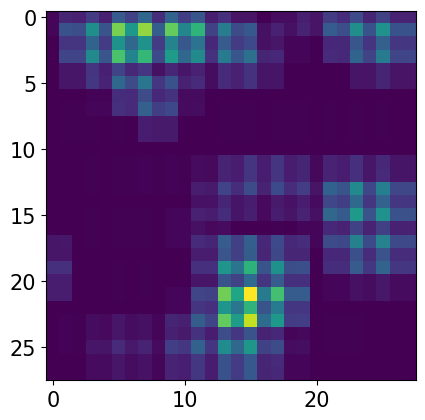

In [666]:
plt.imshow(random_output)

In [667]:
random_preds = []
for i in range(3):

    random_input = torch.randn(vae_model.encoded_cxy).float()#.to(device)
    random_output = 255 * np.moveaxis(nn.ReLU()(vae_model.decoder(random_input)).detach().cpu().numpy().squeeze(), 0, -1)
    random_preds.append(random_output)

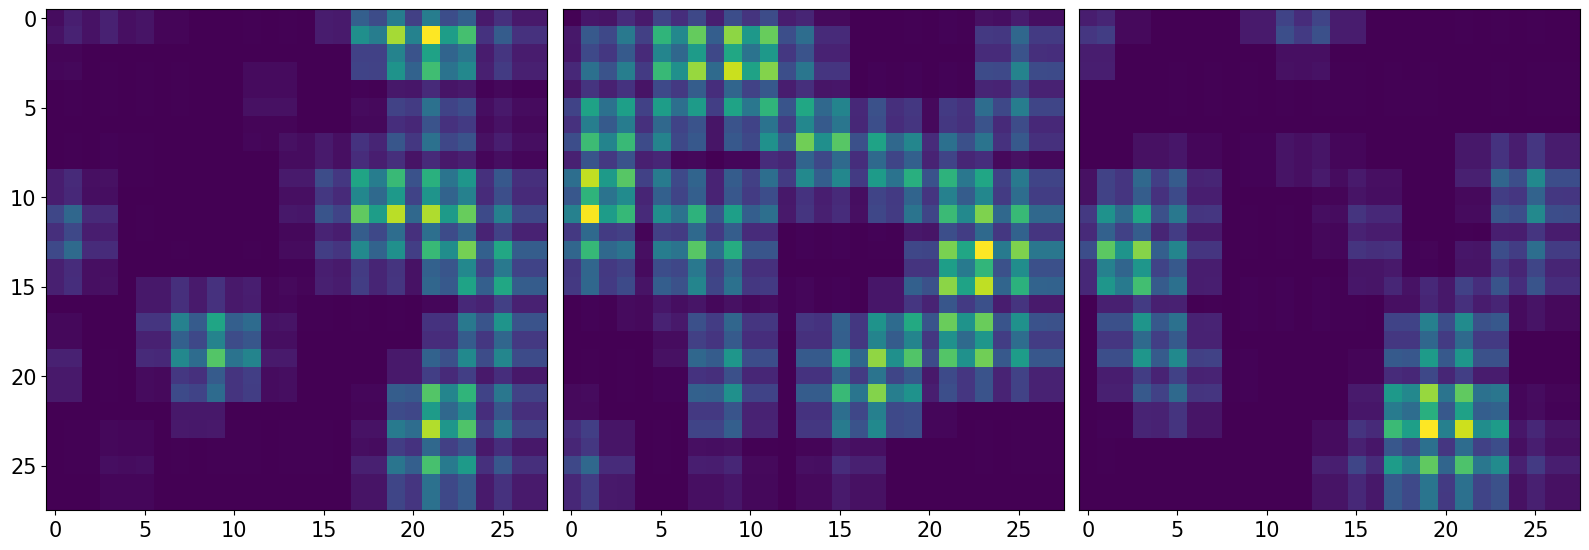

In [668]:
plot_image_panel(random_preds, labels=["", "", ""])